In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, timezone

In [5]:
def get_data(sid, exam, time_adjustment=1):
    eda = pd.read_csv(f'data/{sid}/{exam}/EDA.csv', names=['x'])
    
    session_start_unix = eda.iloc[0, 0]
    sample_rate = eda.iloc[1, 0]
    
    session_start_dt = datetime.fromtimestamp(session_start_unix, tz=timezone.utc)
    exam_start_dt = session_start_dt.replace(hour=session_start_dt.hour+time_adjustment, minute=0, second=0, microsecond=0)
    exam_start_time = int(exam_start_dt.timestamp())
    if exam == 'Final':
        time_1 = exam_start_time + (10_800 / 3)  # 1/3 (1 hour after exam start)
        time_2 = time_1 + (10_800 / 3) # 2/3 (2 hours after exam start)
        time_3 = exam_start_time + 10_800  # Exam end (3 hours after exam start)
    else:
        time_1 = exam_start_time + (5400 / 3)  # 1/3 (1 hour after exam start)
        time_2 = time_1 + (5400 / 3) # 2/3 (2 hours after exam start)
        time_3 = exam_start_time + 5400 
    
    eda = eda.iloc[2:].reset_index(drop=True)  # Remove first two rows (start time & sample rate)
    eda['Timestamp'] = session_start_unix + (eda.index / sample_rate)
    
    conditions = [
    (eda['Timestamp'] < exam_start_time),
    (eda['Timestamp'] >= exam_start_time) & (eda['Timestamp'] < time_1),
    (eda['Timestamp'] >= time_1) & (eda['Timestamp'] < time_2),
    (eda['Timestamp'] >= time_2) & (eda['Timestamp'] < time_3),
    (eda['Timestamp'] >= time_3),
    ]

    labels = ['0-Before Exam', '1-One Third (During)', '2-Two Third (During)', '3-Three Third (During)', '4-After Exam']

    eda['Segment'] = np.select(conditions, labels, default='0')
    
    eda[f'{sid}_{exam}'] = eda.iloc[:, 0]
    return eda.groupby('Segment')[f'{sid}_{exam}'].mean().reset_index()
    

In [6]:
all_data = [(sid, exam) for sid in [f"S{i}" for i in range(1, 11)] for exam in ['Final', 'Midterm 1', 'Midterm 2']]

In [7]:
index = 0
for sid, exam in all_data:
    if index == 0:
        all_exam_data = get_data(sid, exam)
        index += 1
    else:
        all_exam_data = all_exam_data.merge(get_data(sid, exam), on='Segment')

In [8]:
df_transposed = all_exam_data.T
df_transposed.columns = df_transposed.iloc[0]  # Assign first row as column headers
df_transposed = df_transposed[1:].reset_index(drop=True)  # Remove the old first row
df_transposed.head()

Segment,0-Before Exam,1-One Third (During),2-Two Third (During),3-Three Third (During),4-After Exam
0,0.059284,0.175449,0.193167,0.19414,0.025307
1,0.023136,0.023815,0.191496,1.35315,0.146892
2,0.031061,0.200613,0.19054,0.203806,0.046021
3,0.141465,0.139136,0.120121,0.165542,0.015135
4,0.012679,0.011492,0.068991,0.447619,0.160854


In [9]:
index = 0
for sid, exam in all_data:
    if index == 0:
        all_exam_data = get_data(sid, exam)
        index += 1
    else:
        all_exam_data = all_exam_data.merge(get_data(sid, exam), on='Segment')
grade = pd.read_csv('data/ParsedGrades.csv')
grade['name'] = grade['Student'] + '_' + grade['Exam']

def normalize_grades(row):
    return row['Score'] / 200 if row['Exam'] == 'Final' else row['Score'] / 100

# Apply the function to each row
normalized_df = grade.set_index("name").apply(normalize_grades, axis=1).reset_index()
normalized_df.columns = ['Name', 'Percentage_Score']
normalized_df

,Name,Percentage_Score
0,S1_Midterm 1,0.780
1,S2_Midterm 1,0.820
2,S3_Midterm 1,0.770
3,S4_Midterm 1,0.750
4,S5_Midterm 1,0.670
5,S6_Midterm 1,0.710
6,S7_Midterm 1,0.640
7,S8_Midterm 1,0.920
8,S9_Midterm 1,0.800
9,S10_Midterm 1,0.890


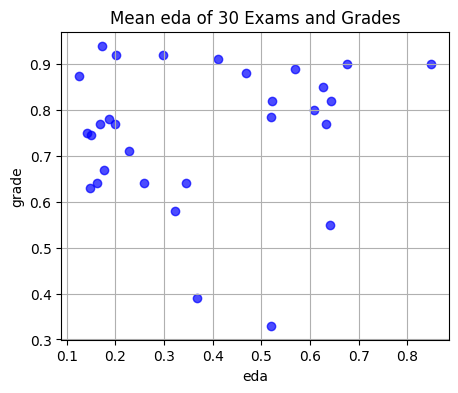

In [10]:
three_means = (df_transposed['1-One Third (During)']+df_transposed['2-Two Third (During)']+df_transposed['3-Three Third (During)'])/3

plt.figure(figsize=(5, 4))
plt.scatter(three_means, normalized_df['Percentage_Score'], color='blue', marker='o', alpha=0.7)
plt.title('Mean eda of 30 Exams and Grades')
plt.xlabel('eda')
plt.ylabel('grade')
plt.grid(True)
plt.show()

In [11]:
df_transposed.to_csv('eda.csv', index=False)